In [24]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, convert_weekly_panel_to_biweekly_panel, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_4_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_weekly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [25]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_week'
df = df.dropna(subset=treatment_date_variable)
df = convert_weekly_panel_to_biweekly_panel(df, treatment_date_variable, analysis)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [26]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                 
                                                 \emph{Independent Variable}                                     
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_4_crimes_50m        2.291019e-02   
                                                 pre_treatment_change_in_group_4_crimes_50m       1.875723e-01   
Panel B: Census Tract Characteristics            frac_coll_plus2010                               2.434923e-03   
                                                 job_density_2013                                 2.102842e-20   
                                                 med_hhinc2016                                    8.489575e-03   
                                                 poor_share2010                                   9.773833e-01   
                                                 popdensity2010                                   2.598599e-03   
Panel C: Case Initiation                         for_cause                                        7.129437e-01   
                                                 no_cause                                         2.882250e-01   
                                                 non_payment                                      6.074288e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                         1.155453e-01   
                                                 hasAttyP                                         3.008884e-01   
                                                 isEntityD                                        4.299119e-01   
                                                 isEntityP                                        4.873977e-01   

                                                                                                           
                                                                                                           
                                                 \emph{Independent Variable}                               
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_4_crimes_50m   1.233493e-02  
                                                 pre_treatment_change_in_group_4_crimes_50m  4.073486e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                          2.196947e-01  
                                                 job_density_2013                            1.019090e-01  
                                                 med_hhinc2016                               4.881476e-02  
                                                 poor_share2010                              9.587528e-01  
                                                 popdensity2010                              2.446323e-03  
Panel C: Case Initiation                         for_cause                                   1.210370e-09  
                                                 no_cause                                    9.538294e-01  
                                                 non_payment                                 3.799494e-08  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                    1.768454e-03  
                                                 hasAttyP                                    3.747346e-04  
                                                 isEntityD                                   6.440755e-02  
                                                 isEntityP                                   4.931512e-07

In [27]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                                  Cases Won by Plaintiff   
Panel A total_twenty_seventeen_group_4_crimes_50m               0.243346   
Panel B frac_coll_plus2010                                      0.330934   
        job_density_2013                                    17324.753036   
        med_hhinc2016                                       48534.175539   
        popdensity2010                                      23285.588974   

                                                  Difference in Cases Won by Defendant  \
                                                                            Unweighted   
Panel A total_twenty_seventeen_group_4_crimes_50m                             0.070631   
Panel B frac_coll_plus2010                                                    0.009828   
        job_density_2013                                                   2509.701466   
        med_hhinc2016                                                      1788.074732   
        popdensity2010                                                     1452.046732   

                                                                          \
                                                   \emph{p}     Weighted   
Panel A total_twenty_seventeen_group_4_crimes_50m  0.012335    -0.013982   
Panel B frac_coll_plus2010                         0.219695     0.013993   
        job_density_2013                           0.101909   -31.215094   
        med_hhinc2016                              0.048815  1919.522232   
        popdensity2010                             0.002446   693.487329   

                                                             
                                                   \emph{p}  
Panel A total_twenty_seventeen_group_4_crimes_50m  0.443790  
Panel B frac_coll_plus2010                         0.078739  
        job_density_2013                           0.982143  
        med_hhinc2016                              0.034795  
        popdensity2010                             0.114548

In [28]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [34]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='varying')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 17688/17688 [02:56<00:00, 100.10it/s]


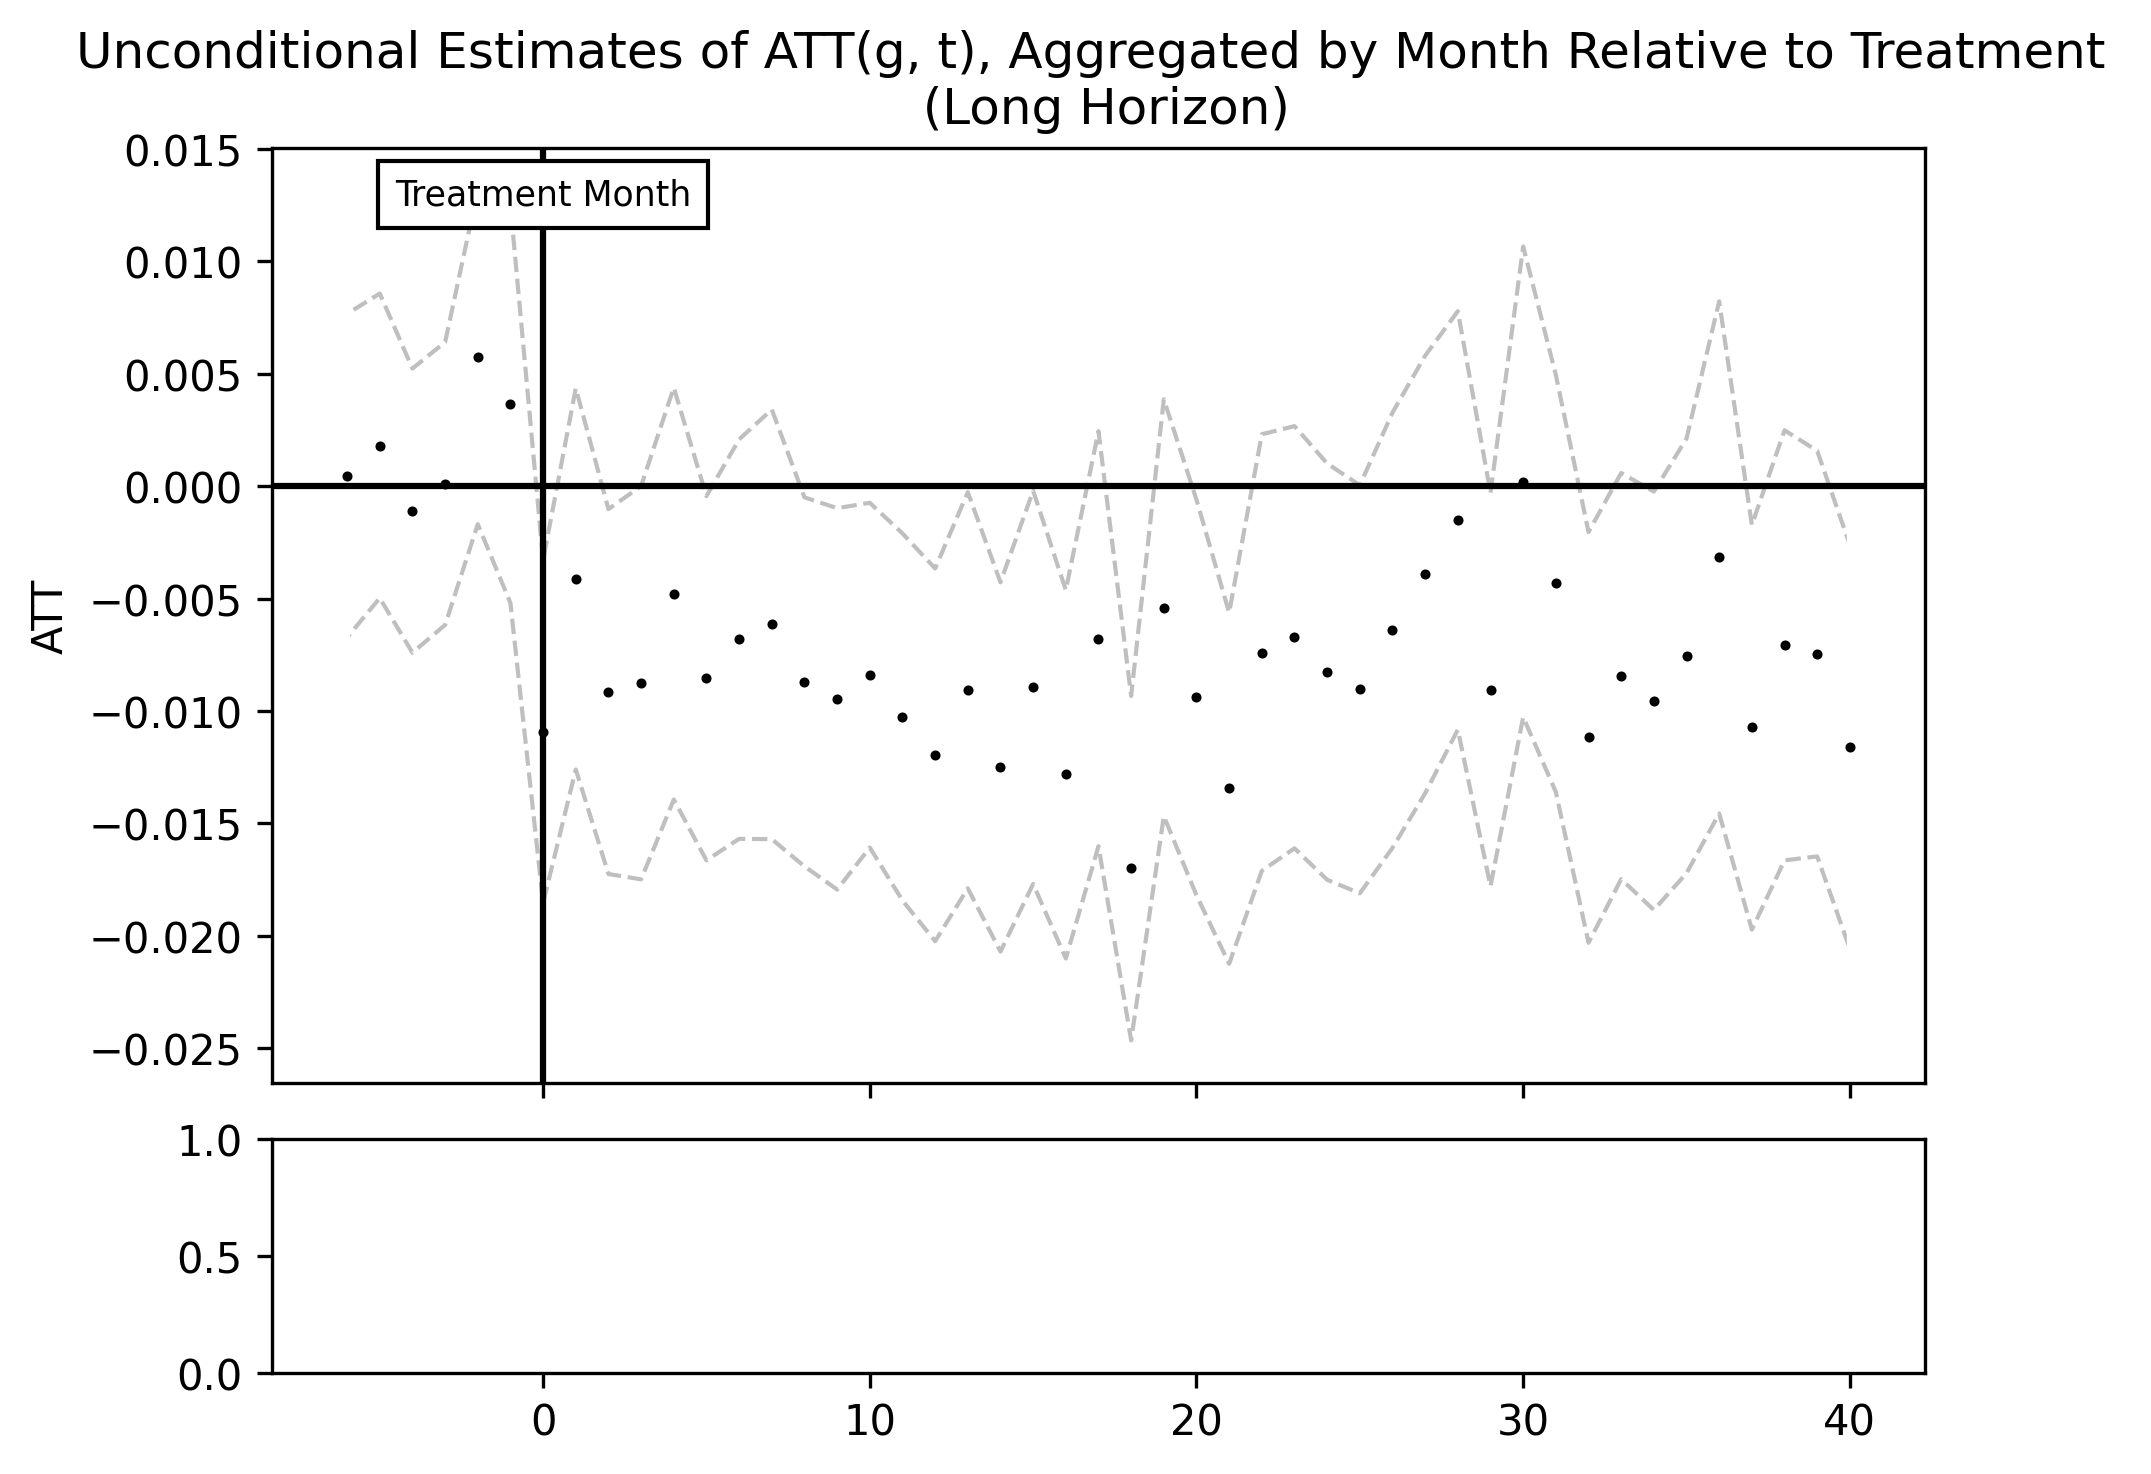

In [35]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-6, end_period=40,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_date_variable, df=df)

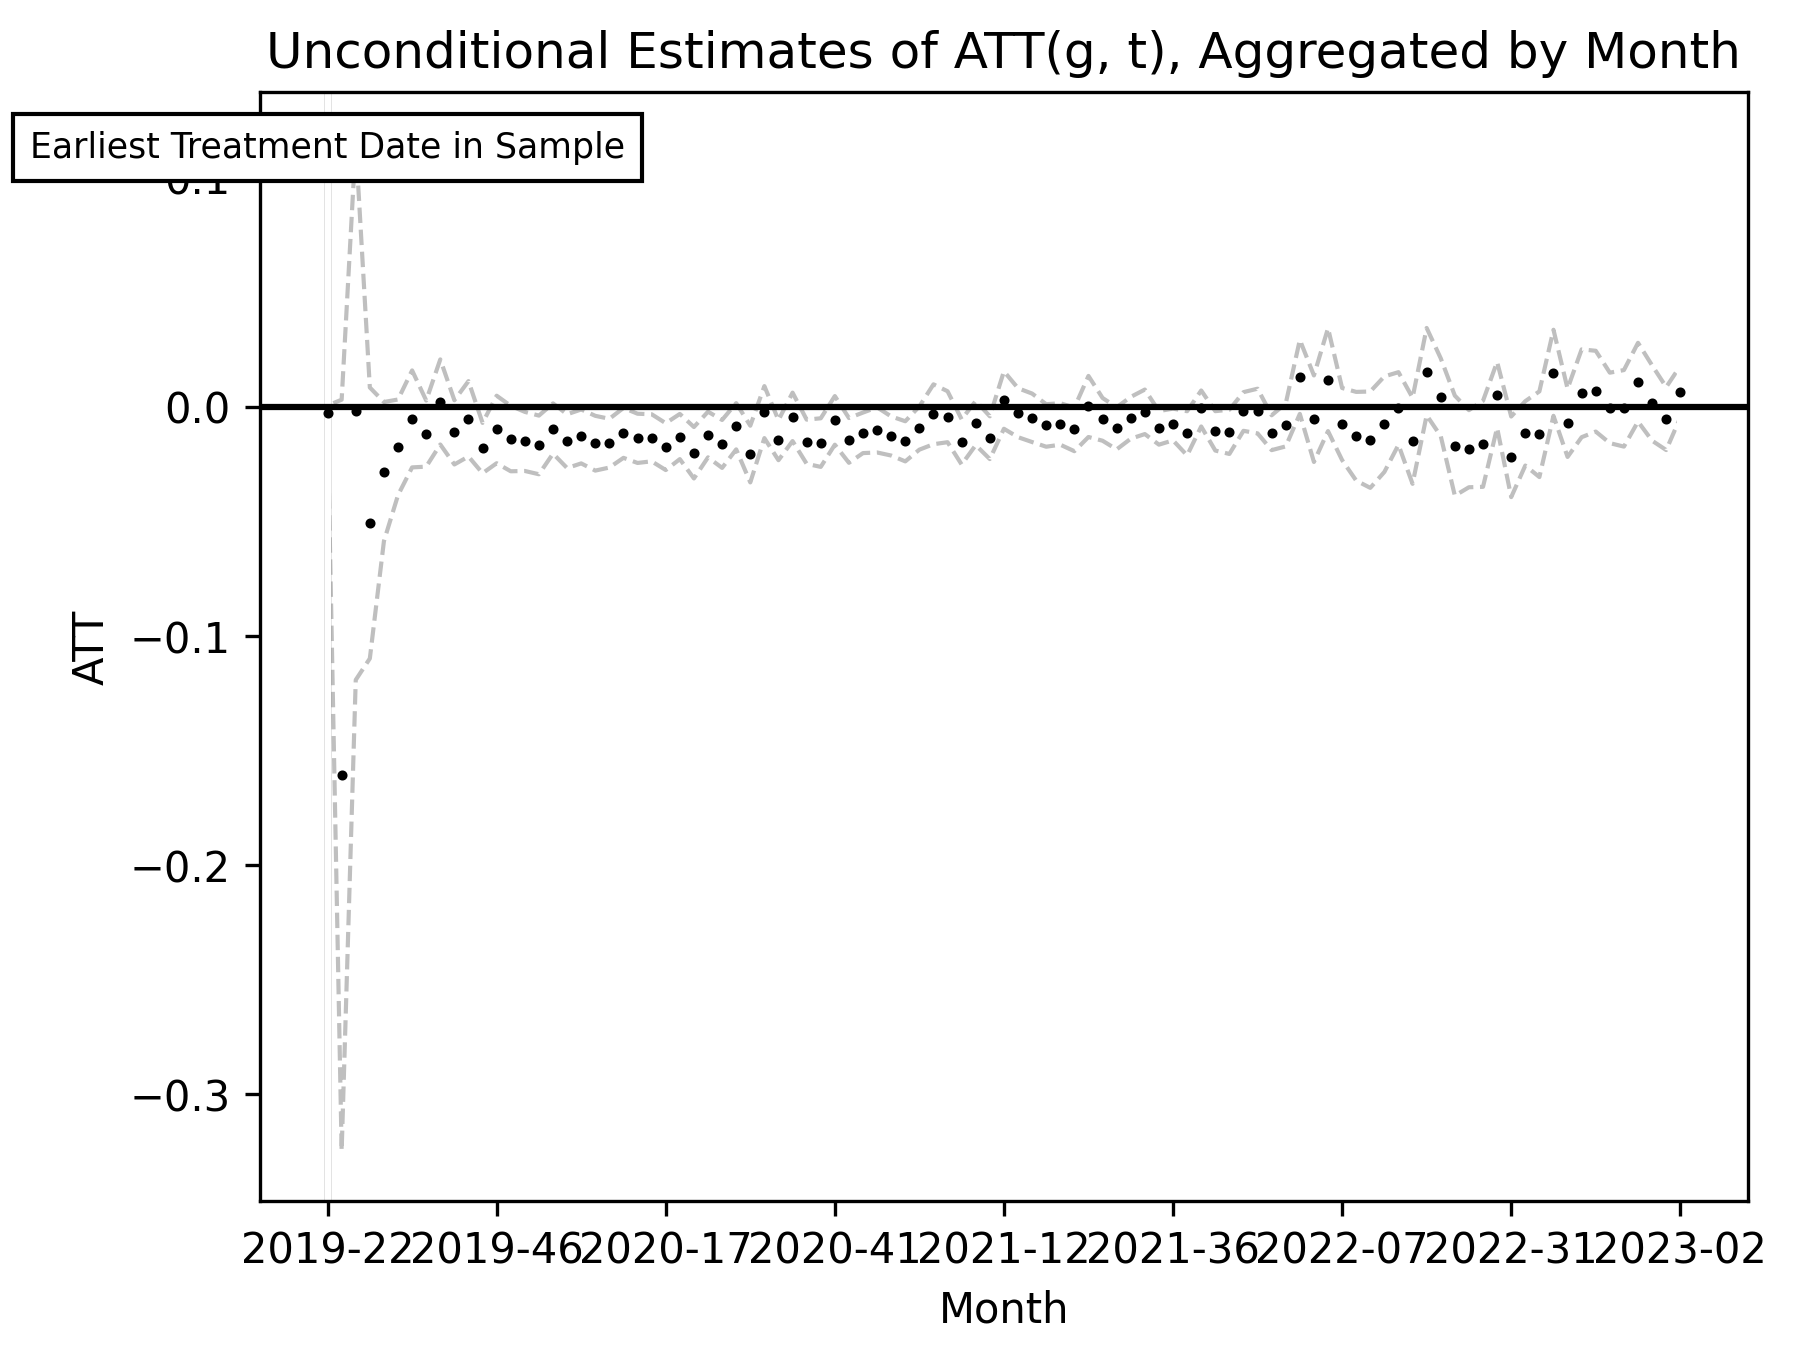

In [31]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="Unconditional Estimates of ATT(g, t), Aggregated by Month")

In [32]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='varying')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]    2%|▍                   | 375/17688 [00:13<10:23, 27.79it/s] 


KeyboardInterrupt: 

In [ ]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-3,
                                 end_period=20,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_date_variable, df=df)

In [ ]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="D.R. Estimates of ATT(g, t), Aggregated by Month")